<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session7/ERA1S7F7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instead of using 7 convolution layer we have now used 8 convolution layer before GAP and maintaining the architecture of the model as same wrt to the other components

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 160099933.17it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 11593041.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 54652500.70it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3699131.80it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


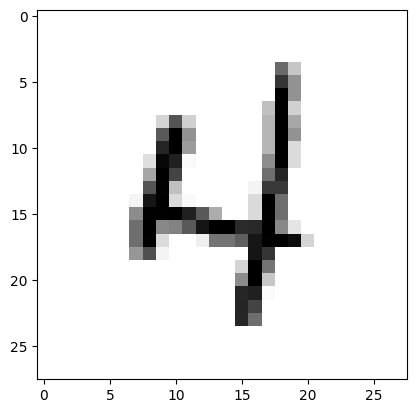

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

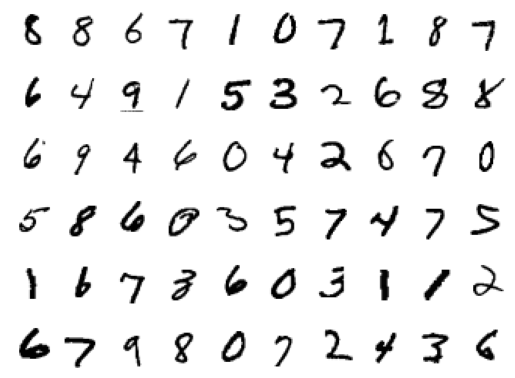

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.16202564537525177 Batch_id=468 Accuracy=82.21: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.4845, Accuracy: 8408/10000 (84.08%)

EPOCH: 1


Loss=0.060784682631492615 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]



Test set: Average loss: 0.2323, Accuracy: 9309/10000 (93.09%)

EPOCH: 2


Loss=0.025998331606388092 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.1280, Accuracy: 9648/10000 (96.48%)

EPOCH: 3


Loss=0.09093820303678513 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:20<00:00, 22.77it/s]



Test set: Average loss: 0.1579, Accuracy: 9504/10000 (95.04%)

EPOCH: 4


Loss=0.008046443574130535 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]



Test set: Average loss: 0.0663, Accuracy: 9809/10000 (98.09%)

EPOCH: 5


Loss=0.03625890240073204 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]



Test set: Average loss: 0.0602, Accuracy: 9826/10000 (98.26%)

EPOCH: 6


Loss=0.034724798053503036 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 29.36it/s]



Test set: Average loss: 0.0715, Accuracy: 9791/10000 (97.91%)

EPOCH: 7


Loss=0.043177638202905655 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]



Test set: Average loss: 0.0712, Accuracy: 9771/10000 (97.71%)

EPOCH: 8


Loss=0.0279033612459898 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]



Test set: Average loss: 0.0435, Accuracy: 9872/10000 (98.72%)

EPOCH: 9


Loss=0.02309044450521469 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]



Test set: Average loss: 0.0513, Accuracy: 9845/10000 (98.45%)

EPOCH: 10


Loss=0.013014686293900013 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]



Test set: Average loss: 0.0797, Accuracy: 9742/10000 (97.42%)

EPOCH: 11


Loss=0.010660731233656406 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]



Test set: Average loss: 0.0579, Accuracy: 9809/10000 (98.09%)

EPOCH: 12


Loss=0.06915104389190674 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]



Test set: Average loss: 0.0410, Accuracy: 9874/10000 (98.74%)

EPOCH: 13


Loss=0.011469408869743347 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:16<00:00, 29.11it/s]



Test set: Average loss: 0.0475, Accuracy: 9861/10000 (98.61%)

EPOCH: 14


Loss=0.005544660147279501 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.19it/s]



Test set: Average loss: 0.0353, Accuracy: 9888/10000 (98.88%)

EPOCH: 15


Loss=0.008468887768685818 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]



Test set: Average loss: 0.0358, Accuracy: 9898/10000 (98.98%)

EPOCH: 16


Loss=0.05167541280388832 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]



Test set: Average loss: 0.0322, Accuracy: 9908/10000 (99.08%)

EPOCH: 17


Loss=0.030930576846003532 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]



Test set: Average loss: 0.0467, Accuracy: 9850/10000 (98.50%)

EPOCH: 18


Loss=0.007091024424880743 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]



Test set: Average loss: 0.0425, Accuracy: 9863/10000 (98.63%)

EPOCH: 19


Loss=0.003341290168464184 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]



Test set: Average loss: 0.0356, Accuracy: 9896/10000 (98.96%)



Text(0.5, 1.0, 'Test Accuracy')

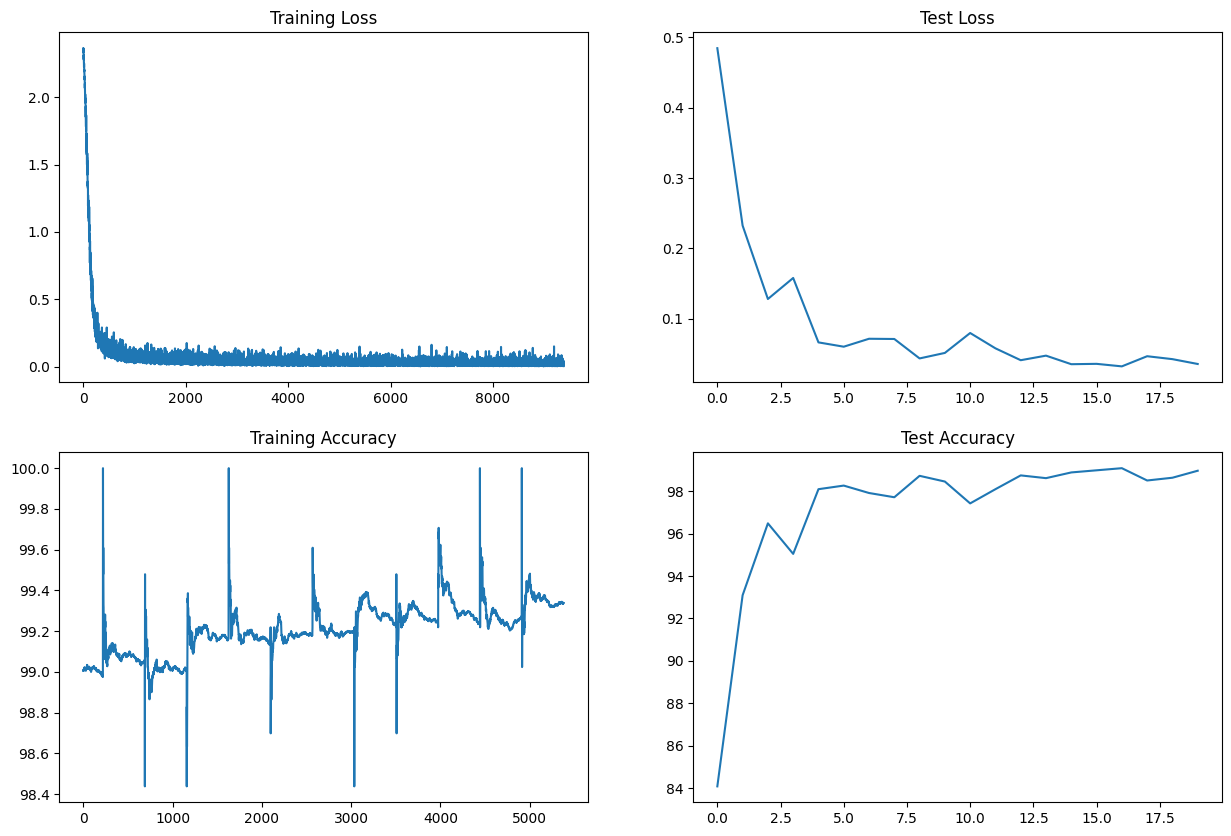

In [12]:
bt = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(bt)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:\
Increase model capacity. Add more layers at the end.

Result:\
Parameters: 11.9k\
Best Train Accuracy: 99.33\
Best Test Accuracy: 99.04

Analysis:\
The model still showing over-fitting, possibly DropOut is not working as expected! Wait yes! We don't know which layer is causing over-fitting. Adding it to a specific layer wasn't a great idea.\
Quite Possibly we need to add more capacity, especially at the end.\
Closer analysis of MNIST can also reveal that just at RF of 5x5 we start to see patterns forming.\
We can also increase the capacity of the model by adding a layer after GAP!